# An eye for feature engineering

## Baseline

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
dino = pd.read_csv("https://storage.googleapis.com/aiolympiadmy/maio_2025_eye_for_feature_engineering.csv", index_col=0)

In [3]:
X, y = dino[["feature1", "feature2"]], dino["class"]

In [4]:
def create_new_feature(X):
    return X["feature1"]

In [5]:
# Create the feature itself
X["feature3"] = create_new_feature(X)

In [6]:
logreg = LogisticRegression()

In [7]:
logreg.fit(X, y)
y_pred_logreg = logreg.predict(X)

In [8]:
print("Logreg precision / recall / f1_score", 
    precision_score(y, y_pred_logreg, zero_division=0, pos_label=1, average="binary"), 
    recall_score(y, y_pred_logreg, zero_division=0, pos_label=1, average="binary"),
    f1_score(y, y_pred_logreg, zero_division=0, pos_label=1, average="binary")
)

Logreg precision / recall / f1_score 0.0 0.0 0.0


## Your task

Above is a peculiar dataset passed through a logistic regression classifier. Notice that the baseline example provided above scores 0 for precision, recall and F1 score. (Google / ask ChatGPT and friends if you're learning of these terms for the first time!)

Do what you can to raise the F1 score as much as possible, subject to the following restrictions:

- You cannot edit the existing model prediction logic in the Your Submission section:
    - except for the cell containing `create_new_feature()` itself
    - except for the cell marked for you to import new libraries
- You can still add new code cells to this notebooks under the Scratchpad section below. Do all your exploration and testing here. However, code in Your Submission must not depend on code in your Scratchpad in any way. Only code from Your Submission will be run during evaluation.

This challenge will be graded via notebook submission only. Scoring as follows:

- Up to 10 pts for model performance, F1 score X 10. Partial credit may be granted for incomplete submissions at discretion. So show your work below!
- +3 pts if F1 score >= 0.5 and no neural networks are involved. Neural networks here are strictly defined as the use of learnable weights and biases
- +2 pts if F1 score >= 0.5 and the `%%timeit` cell reports runtime <= 10 milliseconds


### Scratchpad

In [14]:
# Write all your exploratory code here
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def logreg_test(feature3):
    X_cpy = X.copy()
    X_cpy["feature3"] = feature3

    logreg = LogisticRegression()
    logreg.fit(X_cpy, y)
    y_pred_logreg = logreg.predict(X_cpy)
    
    print("Logreg precision / recall", 
        precision_score(y, y_pred_logreg, zero_division=0, pos_label=1, average="binary"), 
        recall_score(y, y_pred_logreg, zero_division=0, pos_label=1, average="binary"),
        f1_score(y, y_pred_logreg, zero_division=0, pos_label=1, average="binary")
    )

In [16]:
X

,feature1,feature2,feature3
0,55.3846,97.1795,0
1,51.5385,96.0256,0
2,46.1538,94.4872,0
3,42.8205,91.4103,0
4,40.7692,88.3333,0
...,...,...,...
143,80.1538,38.6038,30
144,81.5513,28.6038,30
145,76.8462,34.2962,30
146,83.2821,35.6808,30


In [17]:
XX = X[["feature1", "feature2"]]

In [18]:
y.unique()

array([0, 1], dtype=int64)

<Axes: xlabel='feature1', ylabel='feature2'>

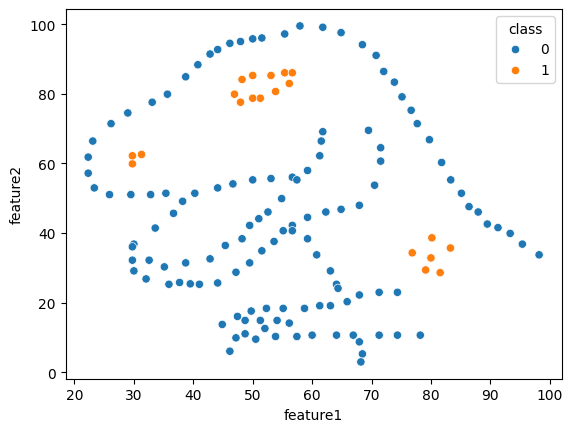

In [19]:
sns.scatterplot(x=X["feature1"], y=X["feature2"], hue=y)

#### Approach 1: Greedy Nearest-Neighbor Clustering

In [20]:
from sklearn.neighbors import NearestNeighbors

In [21]:
def greedy_nearest(XX):
    """
    Go through each unmarked data point, finds its nearest neighbor (ignoring itself), and 
    assigns both the same label, creating a new label if needed.
    """
    n_data = XX.shape[0]
    # n_neighbors=2 because the nearest one is self, the second-nearest is the real neighbor
    knn = NearestNeighbors(n_neighbors=2)
    knn.fit(XX)
    
    unmarked = set(range(n_data))
    res = np.zeros(n_data)
    pick_new = True
    n_color = 1
    i = -1
    while unmarked:
        if i not in unmarked:
            i = unmarked.pop()
        
        neighbor = knn.kneighbors(XX.iloc[[i]], return_distance=False)[0, 1] # shape returned is 1x2
        color = res[i] or res[neighbor]
        if color == 0:
            color = n_color
            n_color += 1
        res[i] = color
        res[neighbor] = color
    
    return res

<Axes: xlabel='feature1', ylabel='feature2'>

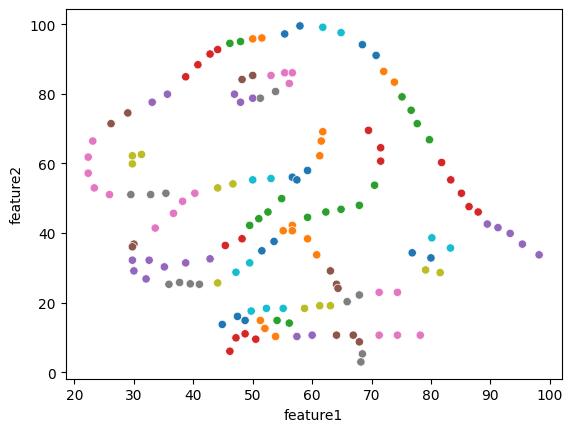

In [22]:
y_pred1 = greedy_nearest(XX)
sns.scatterplot(x=XX["feature1"], y=XX["feature2"], hue=y_pred1, palette="tab10", legend=False)

In [23]:
%%timeit -n 10
greedy_nearest(XX)

136 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Too slow.

In [24]:
logreg_test(y_pred1)

Logreg precision / recall 0.75 0.75 0.75


#### Approach 2: DBSCAN

In [25]:
from sklearn.cluster import DBSCAN

In [26]:
def dbscan(XX, *args, **kwargs):
    db = DBSCAN(*args, **kwargs) 
    return db.fit_predict(XX)

<Axes: xlabel='feature1', ylabel='feature2'>

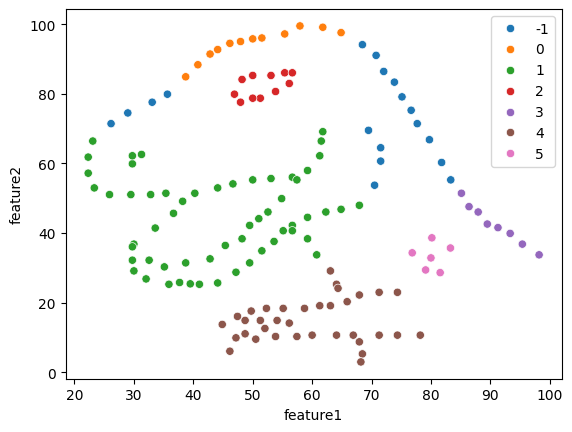

In [27]:
y_pred2 = dbscan(XX, eps=8)
sns.scatterplot(x=XX["feature1"], y=XX["feature2"], hue=y_pred2, palette="tab10")

In [28]:
%%timeit -n 10
dbscan(XX, eps=8)  # A random good eps

2.4 ms ± 708 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
logreg_test(y_pred2)

Logreg precision / recall 1.0 0.85 0.9189189189189189


#### Approach 3: Improved DBSCAN

In [30]:
def draw_dbscan_circles(XX, pred, target_class, eps):
    XX_filtered = XX[pred == target_class]
    plt.figure()
    sns.scatterplot(x=XX["feature1"], y=XX["feature2"], hue=y_pred2, palette="tab10")
    for i in range(XX_filtered.shape[0]):
        circle = plt.Circle(XX_filtered.iloc[i], eps, fill=False, alpha=0.2)
        plt.gca().add_patch(circle)
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python38\\site-packages\\matplotlib\\pyplot.py'>

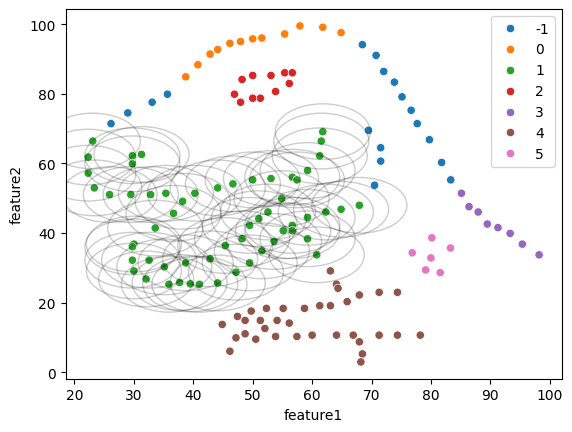

In [31]:
draw_dbscan_circles(XX, y_pred2, 1, 8)

Two key observations can be made:
- The elliptical shape of the circles indicates that the feature axes are not equally scaled.
- Some points fall within the circles but are still classified as outliers (-1), implying that they do not meet the threshold to form a dense region.

What to do?
- Use `StandardScaler`.
- Reduce `min_samples`.

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
std = StandardScaler()
XX_scaled = std.fit_transform(XX)

In [34]:
# To answer:
# What is the largest Euclidean distance of a point to its nearest neighbors?
# Is the nearest neighbor always in the same class as the point?
glb_mx_dist = 0
flag = True
for i in range(len(XX_scaled)):
    mn_dist_of_i = float("inf")
    j_of_mn_dist = i
    
    for j in range(len(XX_scaled)):
        if i == j:
            continue

        dist = np.sqrt(np.sum((XX_scaled[i, :] - XX_scaled[j, :]) ** 2))
        if dist < mn_dist_of_i:
            mn_dist_of_i = dist
            j_of_mn_dist = j

    if y[i] != y[j_of_mn_dist]:
        flag = False
    glb_mx_dist = max(glb_mx_dist, mn_dist_of_i)

glb_mx_dist, flag

(0.2644096224869255, True)

<Axes: >

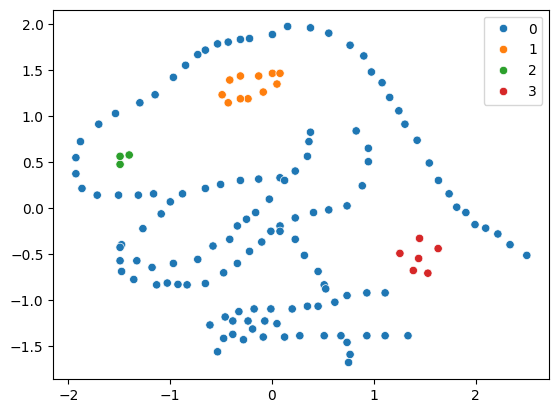

In [35]:
# Set the eps slightly larger than the calculated value above
# Reduce min_samples to minimum
y_pred3 = dbscan(XX_scaled, eps=0.3, min_samples=1)
sns.scatterplot(x=XX_scaled[:, 0], y=XX_scaled[:, 1], hue=y_pred3, palette="tab10")

In [36]:
%%timeit -n 10
dbscan(XX_scaled, eps=0.3, min_samples=1)

1.55 ms ± 559 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
logreg_test(y_pred3)

Logreg precision / recall 1.0 1.0 1.0


## Your submission

In [9]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

In [10]:
# EDIT ME - import additional libraries here
# e.g. import this
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [11]:
# EDIT ME
def create_new_feature(X):
    std = StandardScaler()
    X_scaled = std.fit_transform(X[["feature1", "feature2"]])
    
    db = DBSCAN(eps=0.3, min_samples=1)
    return db.fit_predict(X_scaled) * 10

In [12]:
%%timeit -n 10
# DO NOT EDIT - timing cell
create_new_feature(X)

3.6 ms ± 833 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
# DO NOT EDIT - scoring cell
X["feature3"] = create_new_feature(X)

logreg = LogisticRegression()
logreg.fit(X, y)
y_pred_logreg = logreg.predict(X)

print("Logreg precision / recall", 
    precision_score(y, y_pred_logreg, zero_division=0, pos_label=1, average="binary"), 
    recall_score(y, y_pred_logreg, zero_division=0, pos_label=1, average="binary"),
    f1_score(y, y_pred_logreg, zero_division=0, pos_label=1, average="binary")
)

Logreg precision / recall 1.0 1.0 1.0
